# HW03 Result analysis

### Import necessary libraries

In [1]:
import csv
import numpy as np
try:
    from gensim import models
except ModuleNotFoundError as e:
    !pip install gensim==3.8.0
    from gensim import models
try:
    import pandas as pd
except ModuleNotFoundError as e:
    !pip install pandas
    import pandas as pd    
try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError as e:
    !pip install matplitlib
    import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import precision_recall_fscore_support as score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Function to manage data, load models and extract results

In [2]:
def prepare_data(model_path, data_prefix, seq_len, embedding_size):
    """Function to read specified data and organize it in the desired way
    
    Args:
        model_path (str): path to embedding model
        data_prefix (str): path to data prefix
        seq_len (int): length of each training observation
        embedding_size (int): size of the embedding
        
    Returns:
        
    
    """
    
    def load_data(path):
        output = []
        
        with open(path, 'r', encoding='latin-1') as data:
        #with open(path, 'r', encoding='utf-8') as data:
            for row in csv.reader(data):
                output.append(row)
                
        return output
    
    # Opens embedding model
    model_ = models.Word2Vec.load(model_path)
    
    # Open dataset
    data_train = load_data(data_prefix + "X_train.csv")
    data_val = load_data(data_prefix + "X_val.csv")
    data_test = load_data(data_prefix + "X_test.csv")
    label_train = np.loadtxt(data_prefix + "y_train.csv")
    label_val = np.loadtxt(data_prefix + "y_val.csv")
    label_test = np.loadtxt(data_prefix + "y_test.csv")
    
    # Gets embeddings from model
    dt = []
    lt = []
    omissions_ = 0
    
    for i, seq in enumerate(data_train):
        
        try:        
            embedding = model_.wv[seq]
            dt.append(embedding)
            lt.append(label_train[i])
        
        except KeyError as ke:
            for word in seq:
                if word not in model_.wv.vocab.keys():
                    seq.remove(word)
            
        except ValueError as ve:
            omissions_ += 1
            
#     print(omissions_)
    
    # Gets embeddings from model
    dv = []
    lv = []
    omissions_ = 0
    
    for i, seq in enumerate(data_val):
        
        try:
            embedding = model_.wv[seq]
            dv.append(embedding)
            lv.append(label_val[i])
        
        except KeyError as ke:
            for word in seq:
                if word not in model_.wv.vocab.keys():
                    seq.remove(word)
            
        except ValueError as ve:
            omissions_ += 1
            
    # Gets embeddings from model
    dtest = []
    ltest = []
    omissions_ = 0
    
    for i, seq in enumerate(data_test):
        try:
            embedding = model_.wv[seq]
            dtest.append(embedding)
            ltest.append(label_test[i])
        
        except KeyError as ke:
            for word in seq:
                if word not in model_.wv.vocab.keys():
                    seq.remove(word)
            
        except ValueError as ve:
            omissions_ += 1
    
#     print(omissions_)
    
    # Pads sequences
    dt = pad_sequences(dt, padding='post', dtype='float64', maxlen=seq_len)
    dv = pad_sequences(dv, padding='post', dtype='float64', maxlen=seq_len)
    dtest = pad_sequences(dtest, padding='post', dtype='float64', maxlen=seq_len)
    
    # Converts lists to numpy arrays
#     dt = np.asarray(dt).reshape((len(dt), seq_len * embedding_size))
#     dv = np.asarray(dv).reshape((len(dv), seq_len * embedding_size))
    
    lt = np.asarray(lt)
    lv = np.asarray(lv)
    ltest = np.asarray(ltest)
    
    return dt, dv, lt, lv, dtest, ltest

In [3]:
def create_RNN_model(embedding_size, seq_len, classes, input_shape):
    """
    Function to create RNN model
    
    Args:
        embedding_size (int): Size of the embedding to be used
        seq_len (int): length of each training observation
        classes (int): number of possible classes
        input_shape (int): Shape in which the input will be provided
    
    Returns:
        tensorflow.python.keras.enresourcesgine.sequential.Sequential: RNN model 
    """
    
    model = keras.Sequential([
        layers.SimpleRNN(units = embedding_size, input_shape=input_shape),
        layers.Flatten(),
        layers.Dense((embedding_size * seq_len)/8, activation="relu"),
        layers.Dense(classes, activation='softmax')
    ])
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()]
    )
    return model

def create_LSTM_model(embedding_size, seq_len, classes, input_shape):
    """
    Function to create LSTM model
    
    Args:
        embedding_size (int): Size of the embedding to be used
        seq_len (int): length of each training observation
        classes (int): number of possible classes
        input_shape (int): Shape in which the input will be provided
    
    Returns:
        tensorflow.python.keras.engine.sequential.Sequential: LSTM model 
    """
    
    model = keras.Sequential([
        layers.LSTM(units = embedding_size, input_shape = input_shape),
        layers.Flatten(),
        layers.Dense((embedding_size * seq_len)/8, activation="relu"),
        layers.Dense(classes, activation='softmax')
    ])
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=[keras.metrics.Accuracy(), keras.metrics.Precision(), keras.metrics.Recall()]
    )
    return model
# Dictionary to store model creators
model_creators = {'SimpleRNN': create_RNN_model,
                  'LSTM': create_LSTM_model}

In [4]:
def train_val_model(dataset, em_size, seq_len, model_type, epochs):
    """
    Function to train the given model
    
    Args:
        dataset (str): Name of the dataset to use
        em_size (int): size of the embedding to load
        seq_len (int): lenght of each observation
        model_type (str): model to train
        epochs (int): total epochs to train the model for
    
    Returns:
        PENDING.
    """
    
    if dataset == 'simpson':
        data_path = simpson_dict
    elif dataset == 'friends':
        data_path = friends_dict
    else: 
        raise 'Not valid dataset'

    dt, dv, lt, lv, dtest, ltest = prepare_data(data_path[em_size], data_path['prefix'], seq_len, em_size)
    
    
    data = {'X_train': np.concatenate([dt,dv],axis=0), 'X_test': dtest, 
            'y_train': np.concatenate([lt,lv], axis=0), 'y_test':ltest}
   
    input_shape = (seq_len, em_size)
    
    model = model_creators[model_type](em_size, seq_len, data_path['classes'], 
                                       input_shape=input_shape)
    history = model.fit(data['X_train'], data['y_train'], validation_data=(data['X_test'],data['y_test']), 
                        epochs = epochs, verbose = 0, 
                        class_weight=data_path['weights'])
    return model

In [5]:
def get_model_results(dataset, embedding):
    """ Load and retrain model to run and save results of each stage
    
    Args:
        dataset (str): Name of the dataset to deal with
        embedding (str): Embeddings custom or inside the network
        
    Returns:
        numpy.ndarray: Prediction for train
        numpy.ndarray: True values for train
        numpy.ndarray: Prediction for val
        numpy.ndarray: True values for val
        numpy.ndarray: Prediction for test
        numpy.ndarray: True values for test
    """
    
    if dataset == 'simpson':
        data_path = simpson_dict
    elif dataset == 'friends':
        data_path = friends_dict
    else: 
        raise 'Not valid dataset'
    
    if embedding not in ['deepModels', 'embeddingModels']:
        raise 'Not valid embedding type'
        
    results_path = './results/' + dataset + '/' + embedding + '.csv'
    results_df = pd.read_csv(results_path)
    best_model = results_df[results_df.val_f1 == results_df.val_f1.max()]
    
    model_name = best_model['model_name'][best_model['model_name'].index[0]]
    seq_len = best_model['seq_len'][best_model['seq_len'].index[0]]
    em_size = best_model['embedding_size'][best_model['embedding_size'].index[0]]
    
    model_retrained = train_val_model(dataset, em_size, seq_len, model_name, 20)
    
    path = './results/' + dataset + '/' + embedding +  '/checkpoints/' + str(model_name) + '_' + str(em_size) + '_' + str(seq_len)
    model_loaded = tf.keras.models.load_model(path)
    
    X_train, X_val, y_train, y_val, X_test, y_test = prepare_data(data_path[em_size], 
                                                                  data_path['prefix'], 
                                                                  seq_len, 
                                                                  em_size)
    
    y_pred_train = model_loaded.predict(X_train)
    y_pred_val = model_loaded.predict(X_val)
    y_pred_test = model_retrained(X_test)
    
    return y_pred_train, y_train, y_pred_val, y_val, y_pred_test, y_test

In [6]:
def get_confusion_matrices(results, dataset, embedding):
    """ Show and save confusion matrices for given dataset and result file
    
    Args:
        results (dict): Results for each stage (train, val and test)
        dataset (str): Dataset to deal with
        embedding (str): Embeddings custom or inside the network
    """
    tasks = ['Train', 'Validation', 'Test']
    for task in tasks:
        plt.figure(figsize=(12,8))
        true = results[task]['true']
        pred = results[task]['pred']
        sns.heatmap(confusion_matrix(np.argmax(true, axis=1), 
                                     np.argmax(pred, axis=1), normalize='pred'), cmap='Blues')
        
        plt.title(task + ' confusion matrix', fontsize=20)
        plt.xlabel('Predicted', fontsize=15)
        plt.ylabel('True', fontsize=15)
        plt.savefig('./results/' + dataset + '/' + embedding + '/' + task + '.png')

In [7]:
def create_result_table(results, dataset, embedding):
    """ Show and export to latex metrics per class in each stage
    
    Args:
        results (dict): Results for each stage (train, val and test)
        dataset (str): Dataset to deal with
        embedding (str): Embeddings custom or inside the network
    """
    
    if dataset == 'simpson':
        data_path = simpson_dict
    elif dataset == 'friends':
        data_path = friends_dict
    else: 
        raise 'Not valid dataset'
    
    tasks = ['Train', 'Validation', 'Test']
    for task in tasks:
        true = results[task]['true']
        pred = results[task]['pred']
        
        precision, recall, fscore, support = score(np.argmax(true, axis=1), np.argmax(pred, axis=1))
        
        df = pd.DataFrame(data={'Character': data_path['labels'], 'Precision': precision, 'Recall': recall, 
                                'F1-score': fscore, 'Support': support})
        df.set_index('Character')
        
        caption = dataset.capitalize() + ' ' + embedding + ' ' + task + ' metrics per class.' 
        label = dataset + '_' + task + '_' + embedding
        
        text = df.to_latex(header=True, float_format="%.2f", bold_rows=True, caption=caption, label=label)
        
        text_file = open('./results/' + dataset + '/' + embedding + '/' + task + '.txt', "w")
        n = text_file.write(text)
        text_file.close()

In [8]:
simpson_dict = {15: "./resources/embeddings/Simpsons_15_7.model",
                75: "./resources/embeddings/Simpsons_75_7.model",
                150: "./resources/embeddings/Simpsons_150_7.model",
                'prefix': "./data/simpsons/",
                'classes': 4,
                'weights':{0:2.5, 1:1, 2:3, 3:2.5},
                'labels': ['Lisa', 'Bart', 'Homer', 'Marge']}

friends_dict = {15: "./resources/embeddings/Friends_15_7.model",
                75: "./resources/embeddings/Friends_75_7.model",
                150: "./resources/embeddings/Friends_150_7.model",
                'prefix': "./data/friends/",
                'classes': 6,
                'weights':{0: 1, 1:1, 2:1, 3:1, 4:1, 5:1},
                'labels': ['Monica', 'Joey', 'Chandler', 'Phoebe', 'Ross', 'Rachel']}

### Extract results for each model

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


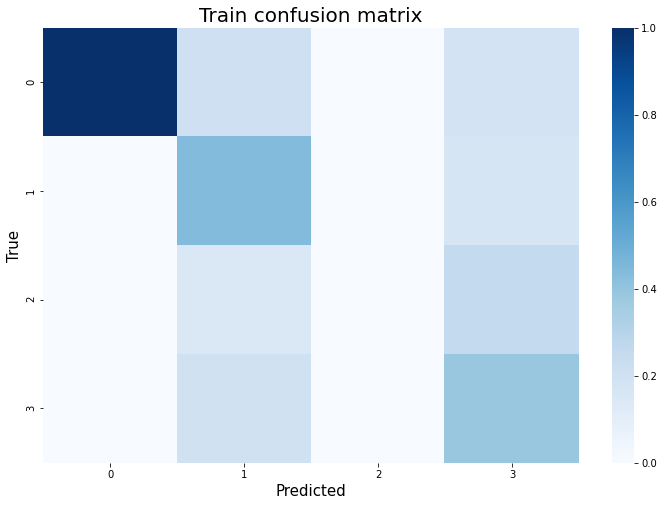

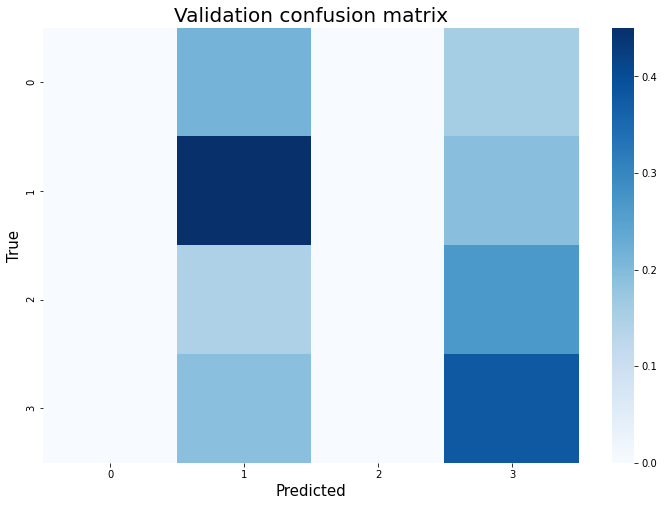

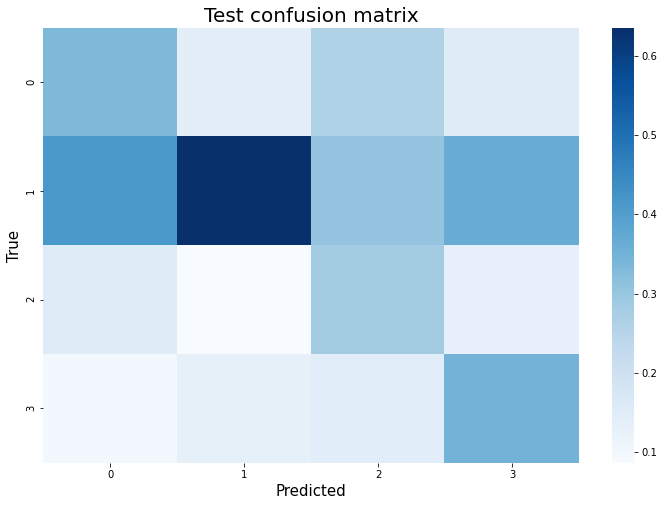

In [9]:
y_pred_train, y_train, y_pred_val, y_val, y_pred_test, y_test = get_model_results('simpson', 'deepModels')
results = {'Train': {'pred': y_pred_train, 'true': y_train},
           'Validation': {'pred': y_pred_val, 'true': y_val},
           'Test': {'pred': y_pred_test, 'true': y_test}}
get_confusion_matrices(results, 'simpson', 'deepModels')
create_result_table(results, 'simpson', 'deepModels')

In [ ]:
y_pred_train, y_train, y_pred_val, y_val, y_pred_test, y_test = get_model_results('friends', 'deepModels')
results = {'Train': {'pred': y_pred_train, 'true': y_train},
           'Validation': {'pred': y_pred_val, 'true': y_val},
           'Test': {'pred': y_pred_test, 'true': y_test}}
get_confusion_matrices(results, 'friends', 'deepModels')
create_result_table(results, 'friends', 'deepModels')

In [ ]:
df = pd.read_csv('./results/simpson/deepModels.csv', index_col =0)
df.set_index(np.linspace(0,len(df)-1,len(df), dtype=np.int8), inplace=True)
label = 'deepModels_Simpson_result'
caption = 'Resultados en el dataset de Los Simpsons'
file = df.to_latex(header=True, float_format="%.2f", bold_rows=True, caption=caption, label=label)
text_file = open('./results/simpson/deepModels/results.txt', "w")
n = text_file.write(file)
text_file.close()

In [ ]:
df.groupby('model_name').mean()[['train_accuracy', 'train_precision', 'train_recall', 'train_f1', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1']].plot.bar(figsize=(12,8), rot=48)
plt.grid()
plt.title('Resultados por modelo', fontsize=20)
plt.xlabel('Tipo de modelo', fontsize=15)
plt.ylabel('Acierto', fontsize=15)
plt.savefig('./results/simpson/deepModels/sim_res_deep_model.png')
df.groupby('embedding_size').mean()[['train_accuracy', 'train_precision', 'train_recall', 'train_f1', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1']].plot.bar(figsize=(12,8), rot=48)
plt.grid()
plt.title('Resultados por tamaño del embedding', fontsize=20)
plt.xlabel('Tipo de modelo', fontsize=15)
plt.ylabel('Acierto', fontsize=15)
plt.savefig('./results/simpson/deepModels/sim_res_deep_em_size.png')
df.groupby('seq_len').mean()[['train_accuracy', 'train_precision', 'train_recall', 'train_f1', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1']].plot.bar(figsize=(12,8), rot=48)
plt.grid()
plt.title('Resultados por longitud de la secuencia', fontsize=20)
plt.xlabel('Tipo de modelo', fontsize=15)
plt.ylabel('Acierto', fontsize=15)
plt.savefig('./results/simpson/deepModels/sim_res_deep_seq_len.png')

In [ ]:
# df = pd.read_csv('./results/friends/deepModels.csv', index_col =0)
# df.set_index(np.linspace(0,len(df)-1,len(df), dtype=np.int8), inplace=True)
# label = 'deepModels_Friends_result'
# caption = 'Resultados en el dataset de Friends'
# file = df.to_latex(header=True, float_format="%.2f", bold_rows=True, caption=caption, label=label)
# text_file = open('./results/friends/deepModels/results.txt', "w")
# n = text_file.write(file)
# text_file.close()

In [ ]:
# df.groupby('model_name').mean()[['train_accuracy', 'train_precision', 'train_recall', 'train_f1', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1']].plot.bar(figsize=(12,8), rot=48)
# plt.grid()
# plt.title('Resultados por modelo', fontsize=20)
# plt.xlabel('Tipo de modelo', fontsize=15)
# plt.ylabel('Acierto', fontsize=15)
# plt.savefig('./results/friends/deepModels/sim_res_deep_model.png')
# df.groupby('embedding_size').mean()[['train_accuracy', 'train_precision', 'train_recall', 'train_f1', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1']].plot.bar(figsize=(12,8), rot=48)
# plt.grid()
# plt.title('Resultados por tamaño del embedding', fontsize=20)
# plt.xlabel('Tipo de modelo', fontsize=15)
# plt.ylabel('Acierto', fontsize=15)
# plt.savefig('./results/friends/deepModels/sim_res_deep_em_size.png')
# df.groupby('seq_len').mean()[['train_accuracy', 'train_precision', 'train_recall', 'train_f1', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1']].plot.bar(figsize=(12,8), rot=48)
# plt.grid()
# plt.title('Resultados por longitud de la secuencia', fontsize=20)
# plt.xlabel('Tipo de modelo', fontsize=15)
# plt.ylabel('Acierto', fontsize=15)
# plt.savefig('./results/friends/deepModels/sim_res_deep_seq_len.png')